In [1]:
### What to try next
# Implement using max Pooling layers instead of conv2d Layers, 
# inspect the encoded information to see what can be done with the DATA
#Ze Hao task ^^^

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

# # This will make the input from -1 to 1, apply nn.Tanh as last layer if this happens
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

mnist_data = datasets.MNIST(root = './data', train = True, download = True, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset = mnist_data, batch_size = 64, shuffle = True)

In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        #Image size:N, 28 * 28
        #reduce this witha few linear layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), #reduce N, 784 > N, 128
            nn.ReLU(), 
            nn.Linear(128, 64), #(inpur, output)
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # Final output > N,3 , 3 output laters
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(), 
            nn.Linear(12, 64), #(inpur, output)
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), 
            #Because the input in 0 and 1, the output should also be between 0 and 1
            #if the input image is in the range of [-1, 1], we use nn.Tanh. Might happen when we apply a normalization
            nn.Sigmoid()
        )
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        


In [8]:
# CNN Usually perform much better

class Autoencoder_CNN(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        #Image size:N, 28, 28
        #reduce this with a few Convolution Layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )
        
# Normally, we can use 
# nn.MaxPool2d -> nn.MaxUnpool2d
# MaxPool will reduce the size, unPool reverse, so we can use in the decoder
        

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
# Create the new model for the CNN Autoencoder

In [9]:
# model = Autoencoder()
model = Autoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [10]:
# Training for CNN Autoencoder

num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #Reconstructed img, Likely going to be 
        recon  = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon, )) 

Epoch:1, Loss:0.0089
Epoch:2, Loss:0.0064
Epoch:3, Loss:0.0043
Epoch:4, Loss:0.0033
Epoch:5, Loss:0.0028
Epoch:6, Loss:0.0032
Epoch:7, Loss:0.0030
Epoch:8, Loss:0.0028
Epoch:9, Loss:0.0028
Epoch:10, Loss:0.0028


(32, 1, 28, 28)
(32, 1, 28, 28)


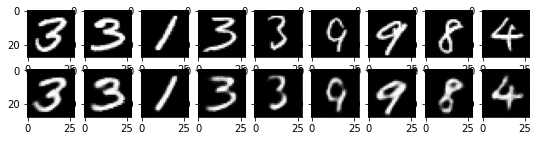

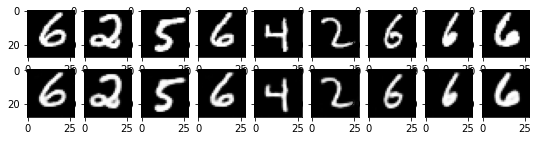

In [44]:
#Plotting the images for convolutional Autoencoder

for k in range(0, num_epochs, 5):
    plt.figure(figsize = (9,2))
    plt.gray()
    
    #because it is a Tensor, so we want to detach and then convert into a numpy array
    imgs = outputs[k][1].detach().numpy()
    print(imgs.shape)
    recon = outputs[k][2].detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9 :
            break
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(item[0])

In [13]:
print(list(model.children()))

[Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
), Sequential(
  (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (5): Sigmoid()
)]


<generator object Module.parameters at 0x00000218A8C8E820>
torch.Size([64, 32, 7, 7])


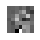

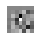

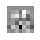

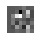

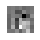

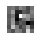

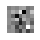

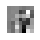

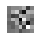

<Figure size 288x288 with 0 Axes>

In [77]:
print(model.parameters())
gen = model.parameters()
next(gen) # 3x3
next(gen) # bias
next(gen) # 3x3
next(gen) # bias
# next(gen) # 7x7
# next(gen) # bias

hold = next(gen) # 3x3
print(hold.shape)


#     self.encoder = nn.Sequential(
#         nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
#         nn.ReLU(),
#         nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
#         nn.ReLU(),
#         nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
#     )

#     # N , 64, 1, 1
#     self.decoder = nn.Sequential(
#         nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
#         nn.ReLU(),
#         nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
#         nn.ReLU(),
#         nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
#         nn.Sigmoid()
#     )
# find imgs, where imgs are the filters
# images = 

# for i, item in enumerate(images):
#     if i >= 9:
#         break
#     plt.subplot(2, 9, i + 1)
#     plt.imshow(item[0])
for i, filter in enumerate(hold[0]):
    plt.figure(figsize = (4,4))
    plt.gray()
    if i >= 9:
        break
    plt.subplot(7, 7, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[ :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

#         if i >= 9:
#             break
#         plt.subplot(2, 9, i + 1)
#         plt.imshow(item[0])

# plt.figure(figsize=(20, 17))
# for i, filter in enumerate(model_weights[0]):
#     plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
#     plt.imshow(filter[0, :, :].detach(), cmap='gray')
#     plt.axis('off')
#     plt.savefig('../outputs/filter.png')
# plt.show()

In [10]:
#Training for Autoencoder

num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #so we reshape to make it flat
        img = img.reshape(-1, 28*28)
        
        #Reconstructed imag, Likely going to be 
        recon  = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0385
Epoch:2, Loss:0.0372
Epoch:3, Loss:0.0314
Epoch:4, Loss:0.0357
Epoch:5, Loss:0.0376
Epoch:6, Loss:0.0406
Epoch:7, Loss:0.0374
Epoch:8, Loss:0.0328
Epoch:9, Loss:0.0336
Epoch:10, Loss:0.0328


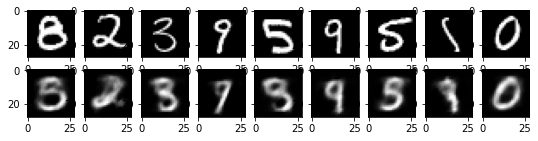

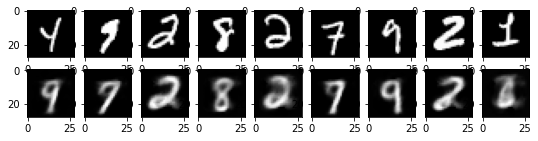

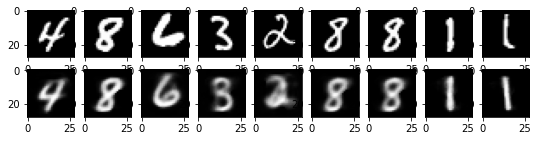

In [19]:
#Plotting the images

for k in range(0, num_epochs, 4):
    plt.figure(figsize = (9,2))
    plt.gray()
    
    #because it is a Tensor, so we want to detach and then convert into a numpy array
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        item = item.reshape(-1, 28, 28)
        
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9 :
            break
        plt.subplot(2, 9, 9 + i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])